### Import Dependencies

In [3]:
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages import convert_to_openai_messages, convert_to_messages

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message

### Single Node Graph

In [4]:
class State(BaseModel):
    message: str
    answer: str = ""
    vibe: str

In [5]:
def append_vibe_to_query(state: State) -> dict:

    return {
        "answer": f"{state.message} {state.vibe}"
    }

In [6]:
workflow = StateGraph(State)

workflow.add_node("append_vibe_to_query", append_vibe_to_query)

workflow.add_edge(START, "append_vibe_to_query")
workflow.add_edge("append_vibe_to_query", END)

graph = workflow.compile()


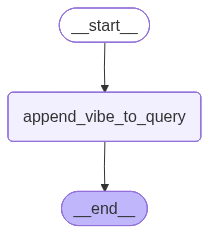

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
initial_state = {
    "message": "Give me some vibes",
    "vibe": "I'm feeling good today!"
}

In [9]:
result = graph.invoke(initial_state)

In [10]:
result

{'message': 'Give me some vibes',
 'answer': "Give me some vibes I'm feeling good today!",
 'vibe': "I'm feeling good today!"}

In [11]:
initial_state = {
    "message": "Give me some vibes",
    "answer": "abc",
    "vibe": "I'm feeling good today!"
}

In [12]:
initial_state

{'message': 'Give me some vibes',
 'answer': 'abc',
 'vibe': "I'm feeling good today!"}

In [13]:
result = graph.invoke(initial_state)

In [14]:
result

{'message': 'Give me some vibes',
 'answer': "Give me some vibes I'm feeling good today!",
 'vibe': "I'm feeling good today!"}

### Conditional Graph

In [15]:
class State(BaseModel):
    message: str
    answer: str = ""    

In [16]:
def append_vibe_to_query(state: State) -> dict:

    return {
        "answer": state.message
    }

In [17]:
def router(state: State) -> Literal["append_vibe_1", "append_vibe_2", "append_vibe_3"]:

    vibe = ["append_vibe_1", "append_vibe_2", "append_vibe_3"]

    vibe_path = random.choice(vibe)

    return vibe_path

In [18]:
def append_vibe_1(state: State) -> dict:

    vibe = "I am feeling good today!"

    return {
        "answer": f"{state.answer}, {vibe}"
    }

def append_vibe_2(state: State) -> dict:

    vibe = "I am feeling bad today!"

    return {
        "answer": f"{state.answer}, {vibe}"
    }
    
    
def append_vibe_3(state: State) -> dict:

    vibe = "I am feeling neutral today!"

    return {
        "answer": f"{state.answer}, {vibe}"
    }

In [19]:
workflow = StateGraph[State, None, State, State](State)

workflow.add_node("append_vibe_to_query", append_vibe_to_query)
workflow.add_node("append_vibe_1", append_vibe_1)
workflow.add_node("append_vibe_2", append_vibe_2)
workflow.add_node("append_vibe_3", append_vibe_3)

workflow.add_conditional_edges(
    "append_vibe_to_query",
    router
)

workflow.add_edge(START, "append_vibe_to_query")
workflow.add_edge("append_vibe_1", END)
workflow.add_edge("append_vibe_2", END)
workflow.add_edge("append_vibe_3", END)

graph = workflow.compile()

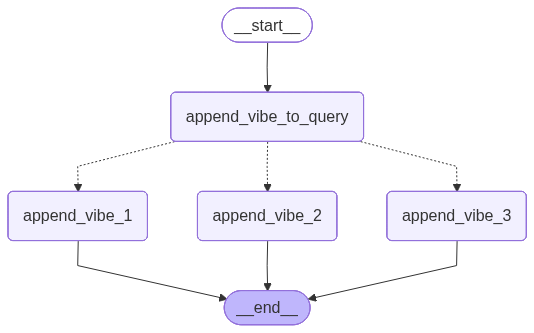

In [20]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
initial_state = {
    "message": "Give me some vibes",
}

In [22]:
result = graph.invoke(initial_state)
result

{'message': 'Give me some vibes',
 'answer': 'Give me some vibes, I am feeling neutral today!'}

### Agent Graph

In [23]:
def append_vibes(query: str, value: str) -> str:
    """
    Takes in a query and a vibe and returns a string with the query and vibe appended.

    Args:
        query: The query to append the vibe to.
        value: The vibe to append to the query.

    Returns:
        A string with the vibe appended.
    """
    return f"{query}, {value}"

In [ ]:
get_tool_descriptions([append_vibes])

[{'name': 'append_vibes',
  'description': 'Takes in a query and a vibe and returns a string with the query and vibe appended.',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string',
     'description': 'The query to append the vibe to.'},
    'value': {'type': 'string',
     'description': 'The vibe to append to the query.'}}},
  'required': ['query', 'value'],
  'returns': {'type': 'string',
   'description': 'A string with the vibe appended.'}}]

In [33]:
class ToolCall(BaseModel):
    name: str
    arguments: dict[str, Any]

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] =[]
    message: str = ""
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []

In [ ]:
def agent_node(state: State) -> dict:

    prompt_template = """
You will be given a selection of tools you can use to add vibes to a user's query.

<Available_tools>
{{ available_tools | tojson }}
</available_tools>

WHen you need to use a tool, format your response as:

<tool_use>
{"name": "tool_name", "arguments": {...}}
</tool_use>

Instructions:
- You need to use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
"""

    template = Template(prompt_template)

    prompt = template.render(
        available_tools = state.available_tools
    )
    
    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = AgentResponse,
        messages = [
            {"role": "system", "content": prompt},
            {"role": "user", "content": state.message}
        ],
        temperature = 0.5
    )

    ai_message = format_ai_message(response)

    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls
    }

#### Short explainer on message types and formating - OpenAI compatible as shown below

In [ ]:
conversatoins = [
    {'role': 'user', 'content': 'Give me some vibes'},
    {'role': 'assistant', 'content': 'I am here to add some vibes'},
    {'role': 'user', 'content': 'I am feeling good today!'}
]

##### Convert between the OpenAI compatible message to Langchain compatible message

In [30]:
convert_to_messages(conversatoins)

[HumanMessage(content='Give me some vibes', additional_kwargs={}, response_metadata={}),
 AIMessage(content='I am here to add some vibes', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I am feeling good today!', additional_kwargs={}, response_metadata={})]

In [31]:
convert_to_openai_messages(convert_to_messages(conversatoins))

[{'role': 'user', 'content': 'Give me some vibes'},
 {'role': 'assistant', 'content': 'I am here to add some vibes'},
 {'role': 'user', 'content': 'I am feeling good today!'}]

In [34]:
dummy_response = AgentResponse(answer = "I am here to add some vibes!", tool_calls = [ToolCall(name = "append_vibe", arguments = {"vibe": "I am feeling good today!"})])

In [35]:
dummy_response

AgentResponse(answer='I am here to add some vibes!', tool_calls=[ToolCall(name='append_vibe', arguments={'vibe': 'I am feeling good today!'})])

In [36]:
format_ai_message(dummy_response)

AIMessage(content='I am here to add some vibes!', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibe', 'args': {'vibe': 'I am feeling good today!'}, 'id': '0', 'type': 'tool_call'}], invalid_tool_calls=[])

#### End of short explainer on message types and formating - OpenAI compatible as shown below

In [ ]:
def tool_router(state: State) -> str:
    """
    Decide whether to continue to END or tool node
    """

    if len(state.tool_calls) > 0:
        return "tool_node"
    else:
        return "end"

In [64]:
workflow = StateGraph[State, None, State, State](State)

tools = [append_vibes]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tool_node": "tool_node",
        "end": END
    }
)
workflow.add_edge("tool_node", END)

graph = workflow.compile()

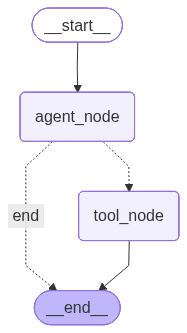

In [65]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
tool_descriptions

[{'name': 'append_vibes',
  'description': 'Takes in a query and a vibe and returns a string with the query and vibe appended.',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string',
     'description': 'The query to append the vibe to.'},
    'value': {'type': 'string',
     'description': 'The vibe to append to the query.'}}},
  'required': ['query', 'value'],
  'returns': {'type': 'string',
   'description': 'A string with the vibe appended.'}}]

In [67]:
initial_state = {
    "message": "Give me some vibes",
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

In [68]:
result

{'messages': [AIMessage(content='Sure! Let me add a vibe to your request.', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes', 'value': 'chill and positive'}, 'id': '0', 'type': 'tool_call'}], invalid_tool_calls=[]),
  ToolMessage(content='Give me some vibes, chill and positive', name='append_vibes', tool_call_id='0')],
 'message': 'Give me some vibes',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the query and vibe appended.',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'The query to append the vibe to.'},
     'value': {'type': 'string',
      'description': 'The vibe to append to the query.'}}},
   'required': ['query', 'value'],
   'returns': {'type': 'string',
    'description': 'A string with the vibe appended.'}}],
 'tool_calls': [ToolCall(name='append_vibes', arguments={'query'

###  Agent Graph with Loopback from Tools (ReAct Agent)

In [69]:
def append_vibes(query: str, value: str) -> str:
    """
    Takes in a query and a vibe and returns a string with the query and vibe appended.

    Args:
        query: The query to append the vibe to.
        value: The vibe to append to the query.

    Returns:
        A string with the vibe appended.
    """
    return f"{query}, {value}"

In [70]:
class ToolCall(BaseModel):
    name: str
    arguments: dict[str, Any]

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] =[]
    message: str = ""
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []

In [89]:
from openai.resources.conversations.conversations import Conversations


def agent_node(state: State) -> dict:

    prompt_template = """
You are an assistant that is generating vibe for a user.
You will be given a selection of tools you can use to add vibes to a user's query.

<Available_tools>
{{ available_tools | tojson }}
</available_tools>

WHen you need to use a tool, format your response as:

<tool_use>
{"name": "tool_name", "arguments": {...}}
</tool_use>

Instructions:
- You need to use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
- You must return a tool call in the first interaction.
"""

    template = Template(prompt_template)

    prompt = template.render(
        available_tools = state.available_tools
    )

    messages = state.messages

    conversations = convert_to_openai_messages(messages)
    
    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model = "gpt-4.1-mini",
        response_model = AgentResponse,
        messages = [
            {"role": "system", "content": prompt},
            *conversations
        ],
        temperature = 0.5
    )

    ai_message = format_ai_message(response)

    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls,
        "iteration": state.iteration + 1,
        "answer": response.answer
    }

In [90]:
def tool_router(state: State) -> str:
    """
    Decide whether to continue to END or tool node
    """

    if state.iteration > 1:
        return "end"
    if len(state.tool_calls) > 0:
        return "tool_node"
    else:
        return "end"

In [91]:
workflow = StateGraph[State, None, State, State](State)

tools = [append_vibes]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tool_node": "tool_node",
        "end": END
    }
)

workflow.add_edge("tool_node", "agent_node")

graph = workflow.compile()

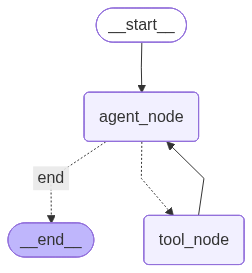

In [92]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [93]:
initial_state = {
    "message": "Give me some vibes",
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

In [94]:
result


{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Tell me a joke', 'value': 'funny'}, 'id': '0', 'type': 'tool_call'}], invalid_tool_calls=[]),
  ToolMessage(content='Tell me a joke, funny', name='append_vibes', tool_call_id='0'),
  AIMessage(content='Tell me a joke, funny', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Tell me a joke', 'value': 'funny'}, 'id': '0', 'type': 'tool_call'}], invalid_tool_calls=[])],
 'message': 'Give me some vibes',
 'iteration': 2,
 'answer': 'Tell me a joke, funny',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the query and vibe appended.',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'The query to append the vibe to.'},
     'value': {'type': 'string',
      'description': 'The vibe t